# Measuring Kinetic Energy of Coupled Classical Harmonic Oscillator Systems using Classiq
Authors: Viraj Dsouza, Cristina Radian, Kerem Yurtseven

Date: 09.08.2024

This work is designed under and for the final project of the Womanium Quantum+AI Program 2024

Reference Paper: Exponential Quantum Speedup in Simulating Coupled Classical Oscillators, Babbush et.al, 2023 [1](https://arxiv.org/abs/2303.13012)
___

## Problem 2

In the paper of Babbush et.al [1](https://arxiv.org/abs/2303.13012), authors assert that the quantum algorithm can estimate the kinetic energy of a system with a finite error. The problem is defined as
>Let $K$ be the $N \times N$ symmetric matrix of spring constants $\kappa_{jk} \geq 0$ and assume it is $d-sparse$ (i.e., there are at most $d$ non-zero entries in each row). Let $M$ be the $N \times N$ diagonal matrix of masses $m_j > 0$ and define the normalized state
\begin{equation*}
    \ket{\psi(t)} := \frac{1}{\sqrt{2E}} \begin{pmatrix} \sqrt{M} \dot{\mathbf{x}}(t) \\ \mathbf{\mu}(t) \end{pmatrix}
    \qquad(1)
\end{equation*}
where $E > 0$ is a constant, and $\mathbf{\mu}(t) \in \mathbb{R}^M\ (M := \frac{N(N + 1)}{2})$ is a vector with $N$ entries $\sqrt{\kappa_{jj}} x_j(t)$ and $\frac{N(N - 1)}{2}$ entries $\sqrt{\kappa_{jk}} (x_j(t) - x_k(t))$, with $k > j$. Assume we are given oracle access to $K$ and $M$, and oracle access to a unitary $W$ that prepares the initial state, i.e., $W \ket{0} \mapsto \ket{\psi(0)}$. Given $t \geq 0$ and $\epsilon > 0$.

>Assume we have an oracle for $V \subseteq [N]$, which is a subset of the oscillators. The oracle outputs an estimate $\hat{k}_V(t) \in \mathbb{R}$ such that
\begin{equation*}
|\hat{k}_V(t) - \frac{K_V(t)}{E}| \leq \epsilon
\qquad(2)
\end{equation*}
where $K_V(t) := \frac{1}{2} \sum_{j \in V} m_j \dot{x}_j(t)$ is the kinetic energy of $V$ at time $t$.

___


## Our Configuration

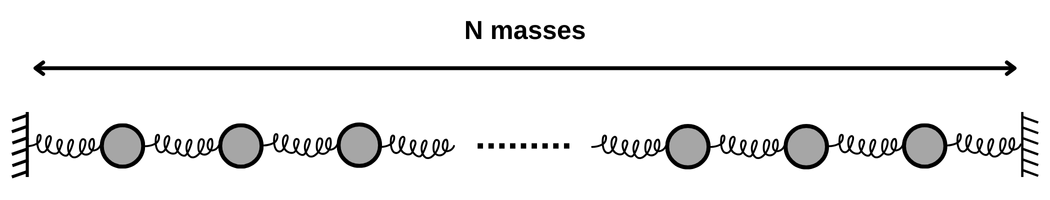

We use $N = 2^3$ masses and evolve it for a certain time. All masses are equal to 1, i.e $m_i = 1$. Also, the spring between each adjacent mass is 1 and initial and final masses are connected to the wall with a spring constant equal to 1. Initial states are chosen as $\vec{x}(t) = (0,0,0,0.....0)^T$ and $\vec{\dot{x}}(t) = (1,0,0,0.....0)^T$

In the post-processing, we get the final velocity vector and evalueate $\hat{k_V}(t)$ as
\begin{equation*}
    \hat{k_V}(t) = \frac{v(t)^T v(t)}{2}
    \qquad(3)
\end{equation*}

___

## Pre-Processing

Create necessary matrix and initial states using functions created in `ccho_helpers.py`

In [8]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from ccho_helpers import *
from classiq import (
    qfunc,
    QNum,
    QArray,
    QBit,
    allocate,
    bind,
    repeat,
    CX,
    control,
    PHASE,
    Output,
    prepare_amplitudes,
    create_model,
    set_execution_preferences,
    synthesize,
    execute,
    suzuki_trotter
) 
from classiq.execution import ExecutionPreferences, ClassiqBackendPreferences

In [2]:
## Providing all inputs for 8 coupled SHO case and performing all the initial transformations

# Number of masses
N=2**3

# Mass Matrix
M= np.zeros([N, N])
for i in range(N):
    M[i][i] = 1

K = np.zeros([N,N])
for j in range(N):
    for t in range(j, N):
        if j == 0 or j == N-1:
            K[j][j] = 1
        if abs(j-t) == 1:
            K[j][t] = 1
            K[t][j] = 1

# Initial Conditions
x_0 = np.zeros([N,1])
xdot_0 = np.zeros([N,1])
xdot_0[0] = 1

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
H = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", H)
print("Initial State:", init_state)

Initial Energy:  0.5
B matrix:  [[ 1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j
   

## Pauli Matrix Decomposition

Create the Pauli List for the Hamiltonian. Pauli Decomposition is taken from [Classiq Library](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) thanks a lot to the authors!

In [3]:
## Pauli Decomposition and transforming it into Classiq syntax

# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(H)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

100%|██████████| 16384/16384 [00:13<00:00, 1258.60it/s]

[('XIIIIIZ', (-0.03125+0j)), ('XIIIIZZ', (-0.03125+0j)), ('XIIIIZX', (-0.03125+0j)), ('XIIIIXI', (-0.015625+0j)), ('XIIIIXZ', (0.015625+0j)), ('XIIIIXX', (0.015625+0j)), ('XIIIIYY', (-0.015625+0j)), ('XIIIZIZ', (-0.03125+0j)), ('XIIIZZZ', (-0.03125+0j)), ('XIIIZZX', (-0.03125+0j)), ('XIIIZXI', (-0.015625+0j)), ('XIIIZXZ', (0.015625+0j)), ('XIIIZXX', (-0.015625+0j)), ('XIIIZYY', (0.015625+0j)), ('XIIIXII', (-0.015625+0j)), ('XIIIXIZ', (0.015625+0j)), ('XIIIXZI', (0.015625+0j)), ('XIIIXZZ', (-0.015625+0j)), ('XIIIXXI', (0.015625+0j)), ('XIIIXXZ', (-0.015625+0j)), ('XIIIXXX', (-0.015625+0j)), ('XIIIXYY', (-0.015625+0j)), ('XIIIYXY', (0.015625+0j)), ('XIIIYYI', (0.015625+0j)), ('XIIIYYZ', (-0.015625+0j)), ('XIIIYYX', (-0.015625+0j)), ('XIIZIIZ', (-0.03125+0j)), ('XIIZIZZ', (-0.03125+0j)), ('XIIZIZX', (-0.03125+0j)), ('XIIZIXI', (-0.015625+0j)), ('XIIZIXZ', (0.015625+0j)), ('XIIZIXX', (0.015625+0j)), ('XIIZIYY', (-0.015625+0j)), ('XIIZZIZ', (-0.03125+0j)), ('XIIZZZZ', (-0.03125+0j)), ('XIIZ

## Hamiltonian simulation

We use the `suzuki_trotter` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$. Since the Hamiltonian for this algorithm is Hermitian by definition, exponentiation methods can be used straightforwardly.

Create the `suzuki_trotter` for each iteration for a time interval. Here, we choose our time interval as $[0,20]$ take $40$ samples with $0.5$ interval.

In [6]:
## Create qfuncs and iterate the loop

# Time List
t_list = np.linspace(0,20,40)
# Kinetic Energy at each time
kinetic_en = []

for t in tqdm.tqdm(t_list):

    # Add i phase for the last half
    @qfunc
    def init_state_phase(state: QNum):
        """
            Definition:
                Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
            Args:
                state (QNum): Initial state with bare amplitudes
            Outputs:
                state (QNum): Initial state with phase
        """

        state_in_qubit = QArray("state_in_qubit")
        msb = QArray("msb", QBit)
        
        size = np.log2(init_state.size)
        allocate(size, msb)

        bind(state, state_in_qubit)
        repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
        control(msb[size-1], lambda: PHASE(np.pi/2, state_in_qubit[size-1]))
        bind(state_in_qubit, state)

    # Main function with suzuki_trotter
    @qfunc
    def main(state: Output[QNum]):
        """
            Definition:
                Main function to make evolution

            Outputs:
                state (Output[QNum]): Resulting state at the t = evolution_coefficient
        """
            
        prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.00000000000001)
        init_state_phase(state)

        suzuki_trotter(
            classiq_pauli_list,
            evolution_coefficient=t,
            order=2,
            repetitions=10,
            qbv=state,
        )

    # Create model and synthesis. Use "simulator_statevector" to take phases into account
    qmod = create_model(main)
    backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
    model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=backend_preferences))
    qprog = synthesize(model_pref)

    # Execute the job
    job = execute(qprog)
    parsed_state_vector = job.result()[0].value.parsed_state_vector

    # Combine the final results
    state_amplitudes = sum_amplitudes_by_state(parsed_state_vector, N)

    # Normalize the global phase
    normalized_final_state = normalize_final_state(state_amplitudes, parsed_state_vector)

    # Eliminate small numbers
    simplified_final_state = simplify_final_state(normalized_final_state)

    # Renormalize the final state using the norm of initial state
    final_state = norm * simplified_final_state[..., None]

    # Take velocities
    xdot_final = final_state[:N]

    ke = np.matmul(xdot_final.T, xdot_final) / 2
    
    kinetic_en.append(ke[0][0])

100%|██████████| 40/40 [1:09:17<00:00, 103.94s/it]


c:\Users\Kerem\anaconda3\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\Kerem\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Kinetic Energy')

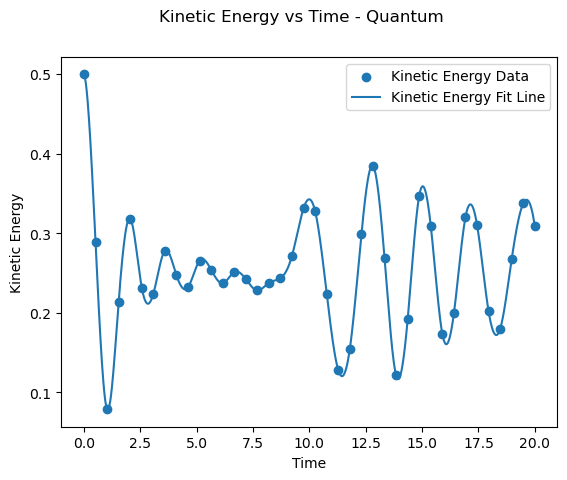

In [74]:
## Plot the Results - Create a Cubic Spline Interpolation to fit the data
spl = scipy.interpolate.CubicSpline(t_list, kinetic_en)
t_new = np.linspace(0,20,1000)

fig, ax = plt.subplots()
fig.suptitle(r"Kinetic Energy vs Time - Quantum")
ax.scatter(t_list, kinetic_en, label=r"Kinetic Energy Data")
ax.plot(t_new, spl(t_new), label=r"Kinetic Energy Fit Line")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Kinetic Energy')

## Classical Results Comparision
Compute classical results numerically and compare it with the quantum results

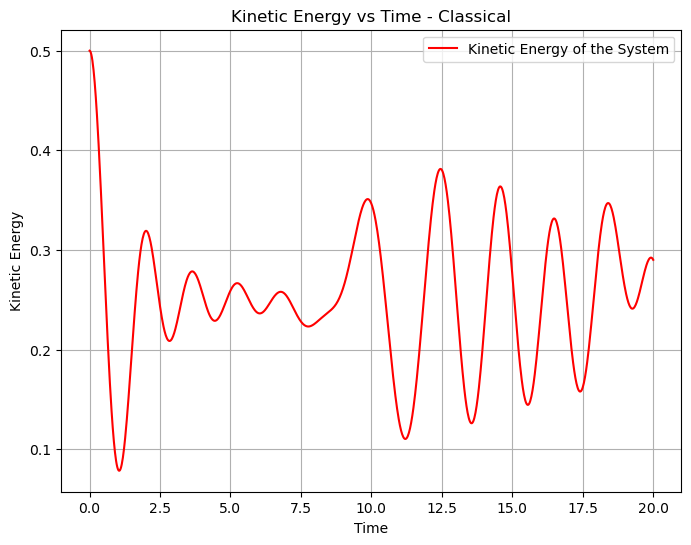

In [73]:
def equations_of_motion(t, init, N, M, K):
    """
    Definition:
        EOM for classical coupled oscillator system with N masses
    Args:
        t (array): Time array
        init (list): Initial Conditions
        N (int): Number of masses
        M (array): Mass matrix (diagonal)
        K (array): Spring constant matrix
    Output:
        (list): List of final equations
    """

    x = init[:N]
    v = init[N:]
    dxdt = v
    dvdt = np.zeros(N)
    
    for i in range(N):
        if i == 0:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]
        elif i == N-1:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i])) / M[i, i]
        else:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i]) + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]

    return np.concatenate((dxdt, dvdt))

# Initial conditions: [x1(0), x2(0), ..., xN(0), v1(0), v2(0), ..., vN(0)]
initial_conditions = np.concatenate((x_0, xdot_0))

# Time span for the simulation
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the system of differential equations
solution = scipy.integrate.solve_ivp(equations_of_motion, t_span, initial_conditions.flatten(), t_eval=t_eval, args=(N, M, K))

# Extract the results
t = solution.t
x = solution.y[:N, :]
v = solution.y[N:, :]

kinetic_classic = []
for vt in v.T:
    e = 0
    for vi in vt:
        e += vi**2/2
    kinetic_classic.append(e)

# Plot position of mass 1
plt.figure(figsize=(8, 6))
plt.plot(t, kinetic_classic, "r", label='Kinetic Energy of the System')
plt.xlabel('Time')
plt.ylabel('Kinetic Energy')
plt.title('Kinetic Energy vs Time - Classical')
plt.grid(True)
plt.legend()
plt.show()

Text(0, 0.5, 'Kinetic Energy')

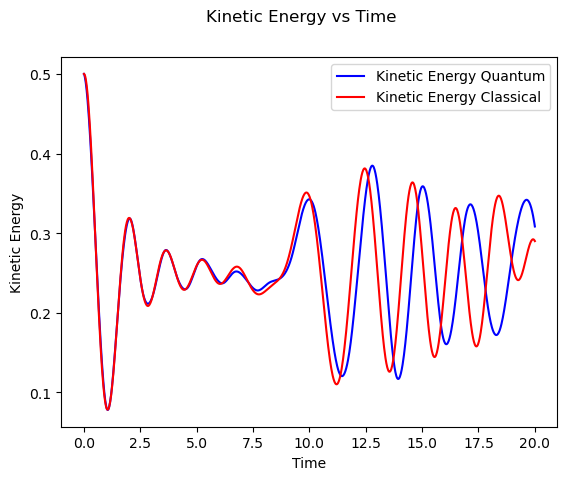

In [52]:
## Plot classical and quantum graphs together
fig, ax = plt.subplots()
fig.suptitle(r"Kinetic Energy vs Time")
ax.plot(t_new, spl(t_new), "b", label=r"Kinetic Energy Quantum")
ax.plot(t, kinetic_classic, "r", label=r'Kinetic Energy Classical')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Kinetic Energy')

Text(0, 0.5, 'Kinetic Energy')

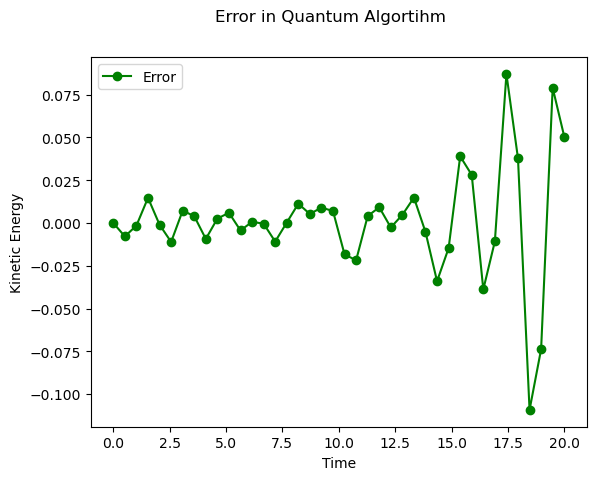

In [71]:
## Difference between classical and quantum solutions
classic_sample = [kinetic_classic[i*25] for i in range(40)]
error = [(kinetic_en[i] - classic_sample[i]) for i in range(40)]

fig, ax = plt.subplots()
fig.suptitle(r"Error in Quantum Algortihm")
ax.plot(t_list, error, "g-o", label=r"Error")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Kinetic Energy')

## Discussion and Results

Results show that quantum algorithm is quite good in estimating the kinetic energy of the system and simulation of **Problem 2** is simulated accurately. It can be said that for the given parameters and configuration, kinetic energy is estimated as:
\begin{equation*}
|\hat{k}_V(t) - K_V(t)| \leq \epsilon
\qquad(4)
\end{equation*}
where $\epsilon$ is $0.025$ for $t \in [0,10]$ and $0.1$ for $t \in [10,20]$


Also, it is noteworthy to say that `suzuki_trotter` parameters "order" and "repetition" is important in the accuracy and to simulate for higher times with high accuracy, these parameters should be chosen higher. By doing a trade-off between simulation times and accuracy, $\epsilon$ can be further improved. More importantly, the effect of Quantum Advantage and Quantum Speedup can be observed with higher masses or more complex cases.

## References
- [1](https://arxiv.org/abs/2303.13012) Exponential Quantum Speedup in Simulating Coupled Classical Oscillators, Babbush et.al, 2023
- [2](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) Classiq Tutorial for HHL
- [3](https://docs.classiq.io/latest/) Classiq Documentation
- Thanks to Eden Schirman, Tomer Goldfriend, and all the Classiq crew!
- Special thanks to Womanium crew for designing and organizing such a good program!